### GPU, cuda, gccの確認


In [ ]:
!nvidia-smi
!nvcc --version
!gcc --version

### パッケージのインストール / クリーンインストール
ssh先のjupyter環境などで実行の場合は, 当該環境にパッケージをインストール

In [ ]:
# クリーンが必要であれば実行
!rm -rf kineticEQ
#!rm -rf build

In [ ]:
# インストール
!git clone https://github.com/Minamium/kineticEQ.git
!pip install -e ./kineticEQ

### 動作確認

In [ ]:
# import packages
%run kineticEQ/tests/base/base_test.py --nv 50 --T_total 0.05 --tau_tilde 5e-9 --dt 5e-4 --lo_iter 64 --lo_tol 1e-6 --ho_iter 64 --ho_tol 1e-6

--- auto compile ---
--- compile cuSOLVER ---
[1/3] g++ -MMD -MF gtsv_binding.o.d -DTORCH_EXTENSION_NAME=gtsv_batch -DTORCH_API_INCLUDE_EXTENSION_H -I/usr/include/python3.12 -isystem /home/IM25D029/.local/lib/python3.12/site-packages/torch/include -isystem /home/IM25D029/.local/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /opt/nvidia/hpc_sdk/Linux_x86_64/25.7/cuda/include -isystem /usr/include/python3.12 -fPIC -std=c++17 -O3 -c /home/IM25D029/work/kineticEQ/src/kineticEQ/backends/gtsv/gtsv_binding.cpp -o gtsv_binding.o 
[2/3] /opt/nvidia/hpc_sdk/Linux_x86_64/25.7/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output gtsv_batch.cuda.o.d -ccbin gcc -DTORCH_EXTENSION_NAME=gtsv_batch -DTORCH_API_INCLUDE_EXTENSION_H -I/usr/include/python3.12 -isystem /home/IM25D029/.local/lib/python3.12/site-packages/torch/include -isystem /home/IM25D029/.local/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /opt/nvidia/hpc_sdk/Linux_

NoneType: None


  device: cuda, GPU name: NVIDIA A30
[LO Picard] iter = 5, residual = 1.277e-05
=== Flux consistency diagnostics ===
  max |(F_LO(LO) - S_HO)' - y_gamma/dt| = 4.609e+04
   L2 |(F_LO(LO) - S_HO)' - y_gamma/dt| = 5.739e+03
  max |F_LO(LO) - F_LO(HO)|            = 8.111e-02
  L2 |F_LO(LO) - F_LO(HO)|             = 7.922e-03


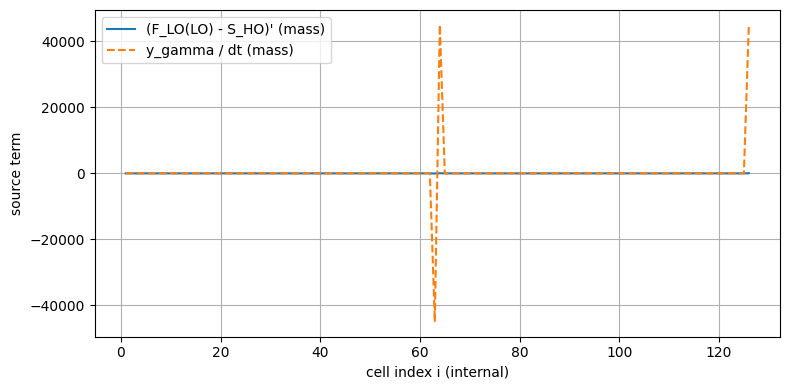

In [1]:
# flux_diag_test.py

import torch
import numpy as np
import matplotlib.pyplot as plt

# kineticEQ の BGK1D を import
# 実際のパッケージ構造に合わせて import 先は適宜修正してください。
from kineticEQ import BGK1D  # 例: from kineticEQ.bgk1d import BGK1D


def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- BGK1D インスタンス作成（ここでは 1 ステップ分だけ使う）---
    bgk = BGK1D(
        solver="implicit",
        implicit_solver="holo",     # HOLO を使う設定だが、このスクリプトでは
                                    # _implicit_update_holo は呼ばず、LO だけ直接使う
        dtype="float64",
        device=device,

        tau_tilde=1.0,
        dt=1.0e-3,
        Lx=1.0,
        T_total=1.0e-3,             # 1 ステップ相当
        nx=128,
        nv=64,
        v_max=5.0,

        use_tqdm=False,
        auto_compile=True,         

        Con_Terms_do=False,         # LO 計算では Y_I_terms を 0 にして呼ぶ
        flux_consistency_do=False,
    )

    # 格子と初期条件・境界をセット
    bgk.Array_allocation()
    bgk.set_initial_condition()
    bgk.apply_boundary_condition()

    # ここでは「初期時刻の HO 分布」を f_ho として用いる。
    f_ho = bgk.f.clone()

    # HO モーメントと熱流束 Q^HO
    n_HO, u_HO, T_HO = bgk.calculate_moments(f_ho)
    Q_HO = bgk._HO_calculate_fluxes(f_ho)

    # HO upwind モーメントも計算（LO 方程式の係数のため）
    S_1_HO, S_2_HO, S_3_HO = bgk._HO_calculate_moments(f_ho)

    # --- LO 系を Y_I_terms=0 で解く（γ を明示的には入れない）---
    nx = bgk.nx
    Y_I_zero = torch.zeros((nx, 3), dtype=bgk.dtype, device=bgk.device)

    n_lo, u_lo, T_lo, tau_lo, lo_residual, lo_iter = bgk._LO_calculate_moments(
        n_HO, u_HO, T_HO, Q_HO,
        S_1_HO, S_2_HO, S_3_HO,
        Y_I_zero
    )

    print(f"[LO Picard] iter = {lo_iter}, residual = {lo_residual:.3e}")

    # --- フラックス整合診断 ---
    diag = bgk.flux_consistency_diagnostics(
        f_ho=f_ho,
        n_lo=n_lo,
        u_lo=u_lo,
        T_lo=T_lo,
        Q_ho=Q_HO,
        dt_for_gamma=None,        # None → self.dt が使われる
        print_summary=True,
    )

    # --- プロット: 質量成分 (n) のみを例として表示 ---
    div_diff_mass = diag["div_diff_flux"][:, 0].numpy()      # (nx-2,)
    y_gamma_mass  = diag["y_gamma_over_dt"][:, 0].numpy()    # (nx-2,)

    x_internal = np.arange(1, nx - 1)  # 内部セルインデックス i=1..nx-2

    plt.figure(figsize=(8, 4))
    plt.plot(x_internal, div_diff_mass, label="(F_LO(LO) - S_HO)' (mass)")
    plt.plot(x_internal, y_gamma_mass, "--", label="y_gamma / dt (mass)")
    plt.xlabel("cell index i (internal)")
    plt.ylabel("source term")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
